# 1.  Import data and libraries

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
caminho_arquivo = '../data/Metro_Interstate_Traffic_Volume.csv'
df = pd.read_csv(caminho_arquivo)

# 2. Basic informations about the dataset

## Head (First Five Rows)

In [17]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Tail (Last Five Rows)

In [18]:
df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


Please note that observations are made on an hourly basis, capturing real-time details such as temperature, precipitation, and weather conditions, with the primary metric being traffic volume.

## Shape (number of rows and columns)

In [19]:
print("\nDataset dimensions (rows, columns):")
df.shape


Dataset dimensions (rows, columns):


(48204, 9)

## Technical Informations

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Note that the 'holiday' column only contains 61 non-null values because only a minority of days are holidays.  

## Analysis of Temporal Gaps

In [21]:
# --- Prepare data of date time ---

# Convert the column 'date_time' to the datetime format of pandas
# Essential for any time series analysis
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index of the DataFrame to make it easier to work with time series data
df = df.set_index('date_time')

# Sort the index to ensure the data is in chronological order
df = df.sort_index()

# Show the start and end of the data to confirm the period
print(f"Start date: {df.index.min()}")
print(f"End date: {df.index.max()}")
print(f"Total records: {len(df)}")


Start date: 2012-10-02 09:00:00
End date: 2018-09-30 23:00:00
Total records: 48204


So, observing the start and end date of the observations, we see that, in fact, the data was collected from October 2012 to September 2018.

# 3. Handle Missing Values

### Find the missing values

In [22]:

# 1. Create an ideal date index, with hourly frequency ('h'),
#    from the first date to the last date recorded in your dataset.
start_date = df.index.min()
end_date = df.index.max()

# 'h' means 'hourly' frequency
ideal_index = pd.date_range(start=start_date, end=end_date, freq='h')

# Print a summary comparing the ideal index with the actual DataFrame index
print(f"Expected records (hourly): {len(ideal_index)}")
print(f"Existing records: {len(df)}")
print(f"Total missing hours: {len(ideal_index) - len(df)}")
print("-" * 60)

# 2. Find out which dates/times are in the ideal index but not in the index of your DataFrame
missing_dates = ideal_index.difference(df.index)

if missing_dates.empty:
    print("No missing time intervals found!")
else:
    print("MISSING FACTS: The following time intervals are missing from the dataset:")
    print(missing_dates)

print(f"\nTotal missing time intervals: {len(missing_dates)}")


Expected records (hourly): 52551
Existing records: 48204
Total missing hours: 4347
------------------------------------------------------------
MISSING FACTS: The following time intervals are missing from the dataset:
DatetimeIndex(['2012-10-03 07:00:00', '2012-10-03 10:00:00',
               '2012-10-03 11:00:00', '2012-10-03 17:00:00',
               '2012-10-05 02:00:00', '2012-10-05 04:00:00',
               '2012-10-06 03:00:00', '2012-10-07 01:00:00',
               '2012-10-07 02:00:00', '2012-10-09 03:00:00',
               ...
               '2018-03-24 05:00:00', '2018-03-24 06:00:00',
               '2018-03-24 07:00:00', '2018-03-29 02:00:00',
               '2018-05-05 02:00:00', '2018-06-02 02:00:00',
               '2018-08-07 07:00:00', '2018-08-07 08:00:00',
               '2018-08-07 09:00:00', '2018-08-23 02:00:00'],
              dtype='datetime64[ns]', length=11976, freq=None)

Total missing time intervals: 11976


There are 11,976 missing time intervals, and now we need to understand why this is happening. Maybe there is some pattern that explains the lack of observations.

### Investigate to Find Patterns 

Initially, I have three possible hypothesis to answer this lack of observations: 

1. Is the data collected only by the day?
2. Isn't the data collected at weekends?
3. Did the sensor break for long times (months or years)?

Let's answer these questions below.

#### Check for patterns by hour

Distribution of missing data by hour of the day (0-23):
0     466
1     479
2     492
3     520
4     486
5     504
6     506
7     517
8     500
9     551
10    485
11    523
12    498
13    517
14    493
15    527
16    483
17    526
18    508
19    507
20    481
21    486
22    471
23    450
Name: count, dtype: int64


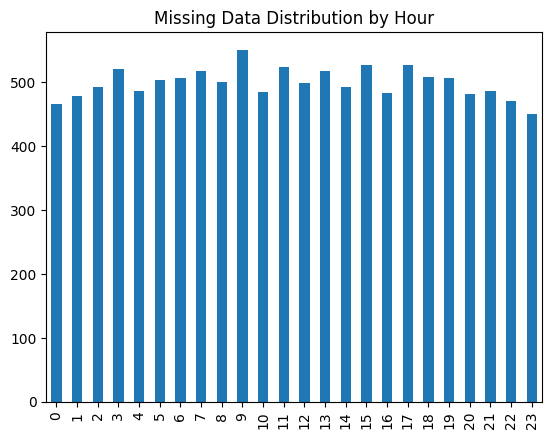

In [23]:
# Count how many times each HOUR of the day is missing
missing_hours_distribution = missing_dates.hour.value_counts().sort_index()
print("Distribution of missing data by hour of the day (0-23):")
print(missing_hours_distribution)

# You might want to plot this to see it better
import matplotlib.pyplot as plt
missing_hours_distribution.plot(kind='bar', title='Missing Data Distribution by Hour')
plt.show()

There is no patterns in missing values by hour

#### Check for patterns by the day of the week

In [24]:
# Count how many times each DAY OF THE WEEK is missing
# (0 = Monday, 6 = Sunday)
missing_dayofweek_distribution = missing_dates.dayofweek.value_counts().sort_index()
print("\nDistribution of missing data by day of the week (0=Mon, 6=Sun):")
print(missing_dayofweek_distribution)


Distribution of missing data by day of the week (0=Mon, 6=Sun):
0    1689
1    1800
2    1709
3    1715
4    1635
5    1728
6    1700
Name: count, dtype: int64


There is no patterns of missing values by the day of the week

#### Check for patterns by year


Distribution of missing data by Year-Month:
Year  Month
2012  10        44
      11        14
      12        14
2013  1        139
      2         78
              ... 
2018  1          2
      3         11
      5          1
      6          1
      8          4
Length: 63, dtype: int64


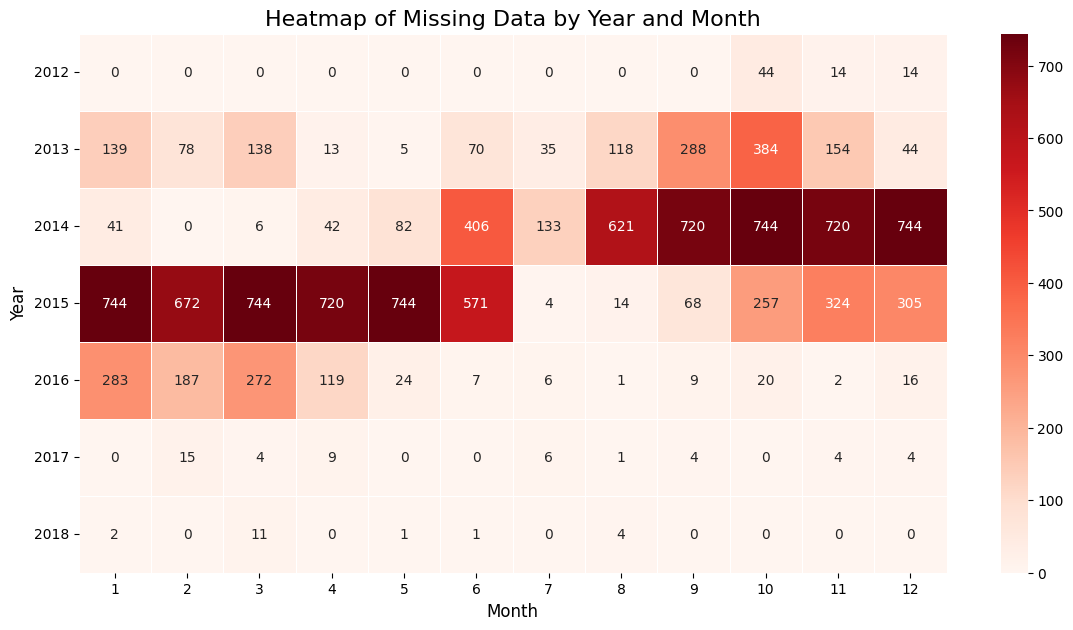

In [25]:
# Convert the DatetimeIndex to a Series to use .groupby()
missing_series = missing_dates.to_series()

# Group by both the year and the month of the index, then count the size of each group
missing_year_month_distribution = missing_series.groupby(
    [missing_series.index.year, missing_series.index.month]
).count()

# Rename the axes for clarity
missing_year_month_distribution.index.names = ['Year', 'Month']

print("\nDistribution of missing data by Year-Month:")
print(missing_year_month_distribution)

import matplotlib.pyplot as plt
import seaborn as sns

# Your data from the previous step (assuming it's named 'missing_year_month_distribution')
# missing_year_month_distribution = ...

# --- Plotting Code ---

# 1. Reshape the data for the heatmap
# We need to "unstack" the MultiIndex. We'll put 'Month' on the columns.
# .fillna(0) is important, as it fills in months that had 0 missing values.
try:
    data_heatmap = missing_year_month_distribution.unstack(level='Month').fillna(0)
    
    # 2. Create the plot
    plt.figure(figsize=(14, 7)) # Make the figure wider to fit 12 months
    
    # 3. Draw the heatmap
    sns.heatmap(
        data_heatmap, 
        annot=True,     # Show the numbers in each cell
        fmt=".0f",      # Format the numbers as integers (no decimals)
        cmap='Reds',    # Use a color scale from light to dark red
        linewidths=.5     # Add thin lines between cells
    )
    
    plt.title('Heatmap of Missing Data by Year and Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Year', fontsize=12)
    plt.yticks(rotation=0) # Ensure Y-axis (Year) labels are horizontal
    
    plt.show()
    plt.close()

except Exception as e:
    print(f"An error occurred while creating the heatmap: {e}")
    print("This can happen if 'missing_year_month_distribution' is empty.")


So it is evident that the period 08/2014 - 06/2015 has several missing timestamps.

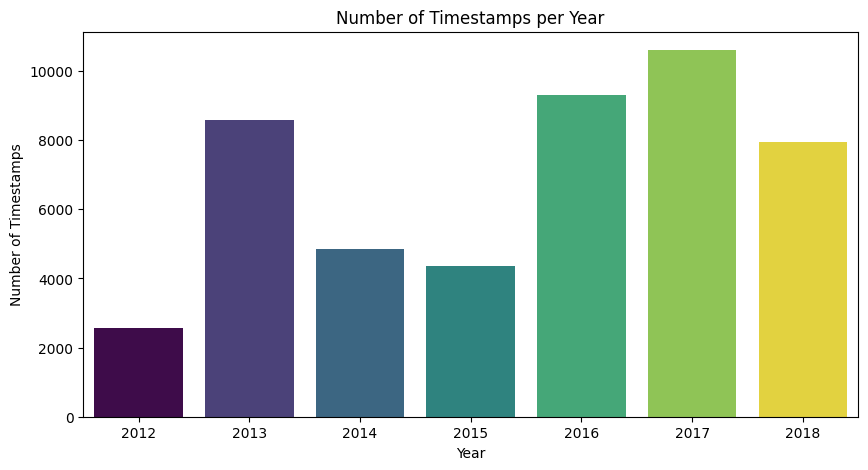

In [26]:
# analysing distribution of number of timestamps by year
timestamps_per_year = df.index.year.value_counts().sort_index()

# plotting the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=timestamps_per_year.index, y=timestamps_per_year.values, hue=timestamps_per_year.index, palette='viridis', legend=False)
plt.title('Number of Timestamps per Year')
plt.xlabel('Year')
plt.ylabel('Number of Timestamps')
plt.show()


### CRITICAL CHOICE: Drop or Impute timestamps in the period 08/2014 - 06/2015?

Given that the period with many missing observations is extensive (almost an entire year), the best approach would be to 
discard this data rather than attempting to impute it. Imputation could introduce significant biases, especially if traffic patterns during that period were different from other periods. 

Furthermore, not removing the data from this period breaks temporal continuity, which is crucial for time series analyses. Therefore, the most prudent decision is to eliminate these observations to maintain the integrity and reliability of subsequent analysis.

#### Decision: Drop timestamps from 08/2014 - 06/ (it will be done in the next notebook)

### Another question: Do the others timestamps at other periods with many missing observations need to be dropped too?

There are another periods with several (> 20%) missing timestamps, some of them are:

- 08/2013 (384 missing timestamps)
- 06/2014 (406 missing timestamps)
- 11/2015 (324 missing timestamps)
- 12/2015 (305 missing timestamps)
- 09/2013 (288 missing timestamps)

To check if these periods need to be dropped too, we want to plot the timestamps for these months and see if there is a large continuous gap or if the gaps are small and spaced out. If the failures are scattered, we can do seasonal imputation. Otherwise, the density of missing data and the continuity of the gaps prevent reliable imputation without introducing "significant synthetic bias".

### But, before we need to remove duplicates

To resolve duplicate data, I used two aggregation rules:

* Rule for numerical data: mean
* Rule for categorical data: first occurrence

In [29]:

# Check how many duplicates exist
print(f"Number of duplicate rows (by index): {df.index.duplicated().sum()}")

# --- Handle Conflicting Duplicate Timestamps ---

# 1. Define which columns are numeric and which are categorical
#    (Note: 'traffic_volume' is treated as numeric for aggregation)
numeric_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']
categorical_cols = ['holiday', 'weather_main', 'weather_description']

# 2. Create a dictionary of aggregation rules
agg_rules = {}

# Rule for numeric: take the mean
for col in numeric_cols:
    agg_rules[col] = 'mean'

# Rule for categorical: take the first occurrence
for col in categorical_cols:
    agg_rules[col] = 'first'

print("Aggregation rules defined:")
print(agg_rules)
print("-" * 60)

# 3. Group by the index (timestamp) and apply the aggregation rules
#    This will merge all rows with the same timestamp into one.
df_aggregated = df.groupby(df.index).agg(agg_rules)

# 4. Check the results
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after aggregation: {len(df_aggregated)}")
print(f"Number of duplicate timestamps now: {df_aggregated.index.duplicated().sum()}")

# Now, use this df_aggregated for your analysis
df = df_aggregated.copy()

Number of duplicate rows (by index): 7629
Aggregation rules defined:
{'temp': 'mean', 'rain_1h': 'mean', 'snow_1h': 'mean', 'clouds_all': 'mean', 'traffic_volume': 'mean', 'holiday': 'first', 'weather_main': 'first', 'weather_description': 'first'}
------------------------------------------------------------
Original number of rows: 48204
Number of rows after aggregation: 40575
Number of duplicate timestamps now: 0


### Now, we will automatically identify what months need to be dropped based on the criteria of having more than 20% of missing timestamps and plot them to visually inspect the gaps. 

But, the months at the critical period (08/2014 - 06/2015) will not be considered, since we already decided to drop this entire period.

In [32]:
# 1. Re-calculate missing dates after aggregation
ideal_index_agg = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_dates_agg = ideal_index_agg.difference(df.index)

# 2. Group missing dates by Year-Month
missing_series_agg = missing_dates_agg.to_series()
missing_by_month = missing_series_agg.groupby([missing_series_agg.index.year, missing_series_agg.index.month]).count()
missing_by_month.index.names = ['Year', 'Month']

# 3. Calculate total possible hours in each month
total_hours_per_month = ideal_index_agg.to_series().groupby([ideal_index_agg.year, ideal_index_agg.month]).count()
total_hours_per_month.index.names = ['Year', 'Month']

# 4. Calculate the percentage of missing data
missing_percentage = (missing_by_month / total_hours_per_month) * 100
missing_percentage = missing_percentage.rename('Missing_Pct')

# 5. Define the critical period to exclude
critical_period_start = '2014-08'
critical_period_end = '2015-06'

# Create a boolean mask for rows outside the critical period
outside_critical_period_mask = ~missing_percentage.index.map(
    lambda ym: (critical_period_start <= f"{ym[0]}-{ym[1]:02d}" <= critical_period_end)
)

# 6. Identify months to drop (outside critical period and > 20% missing)
months_to_investigate = missing_percentage[outside_critical_period_mask & (missing_percentage > 20)]

print("Months with >20% missing data (excluding critical period 08/2014-06/2015):")
print(months_to_investigate)

Months with >20% missing data (excluding critical period 08/2014-06/2015):
Year  Month
2013  9        40.000000
      10       51.612903
      11       21.388889
2014  6        56.388889
2015  10       34.543011
      11       45.000000
      12       40.994624
2016  1        38.037634
      2        26.867816
      3        36.559140
Name: Missing_Pct, dtype: float64


### Now, we can plot the periods with many missing timestamps


--- Plotting Gaps for Months to Investigate ---
--- Analyzing: 2013-09 ---
Total hours: 720
Missing hours: 288 (40.00%)


/tmp/ipykernel_2158/3793636004.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=start_date, end=end_date, freq='H')


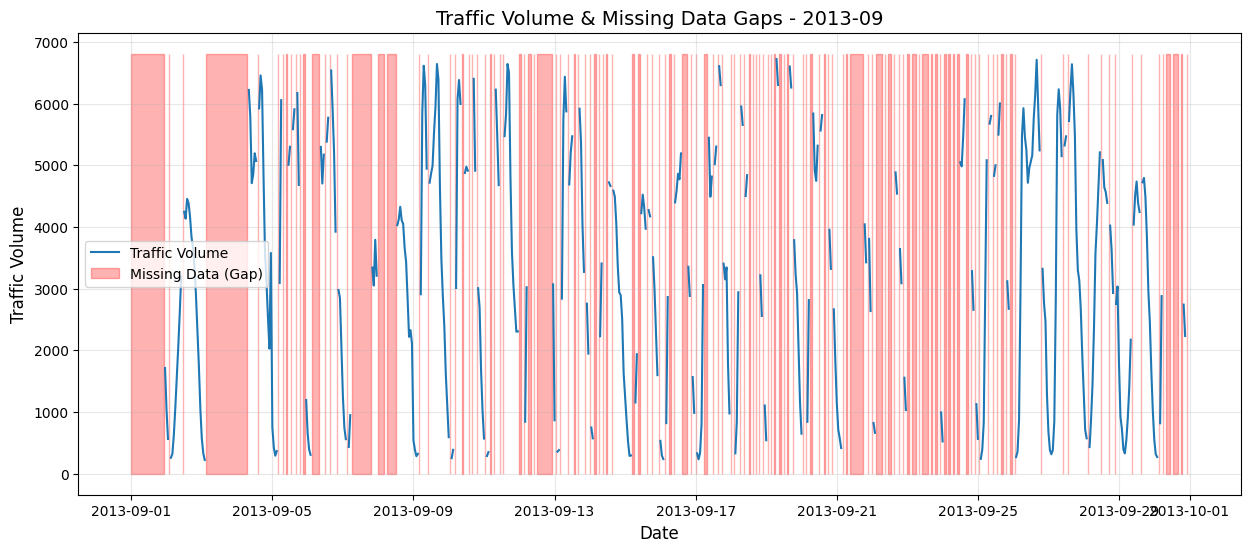

--- Analyzing: 2013-10 ---
Total hours: 744
Missing hours: 384 (51.61%)


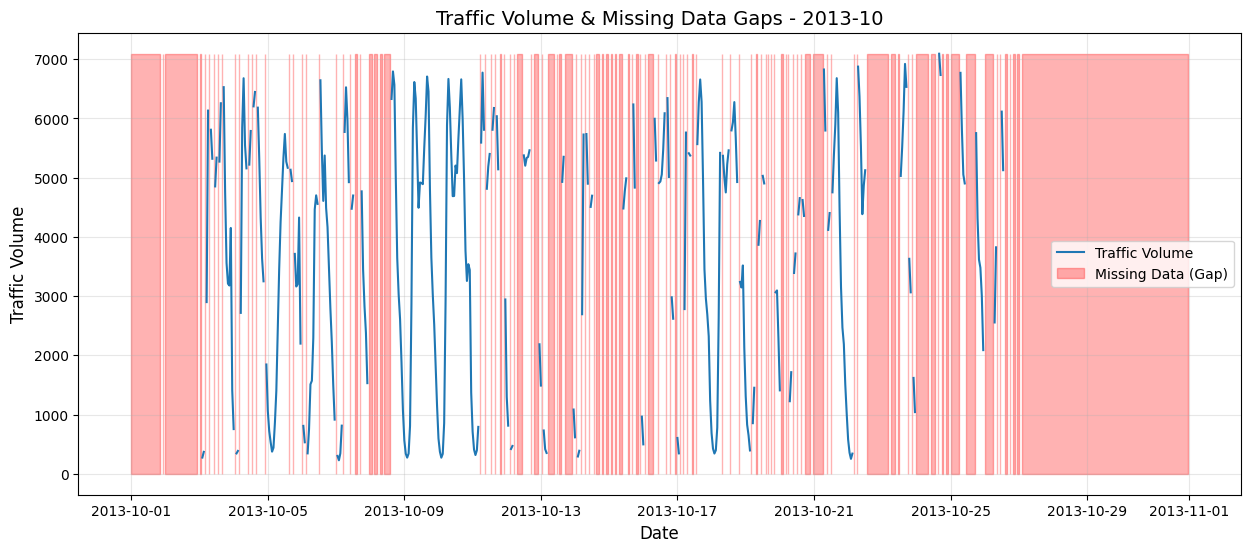

--- Analyzing: 2013-11 ---
Total hours: 720
Missing hours: 154 (21.39%)


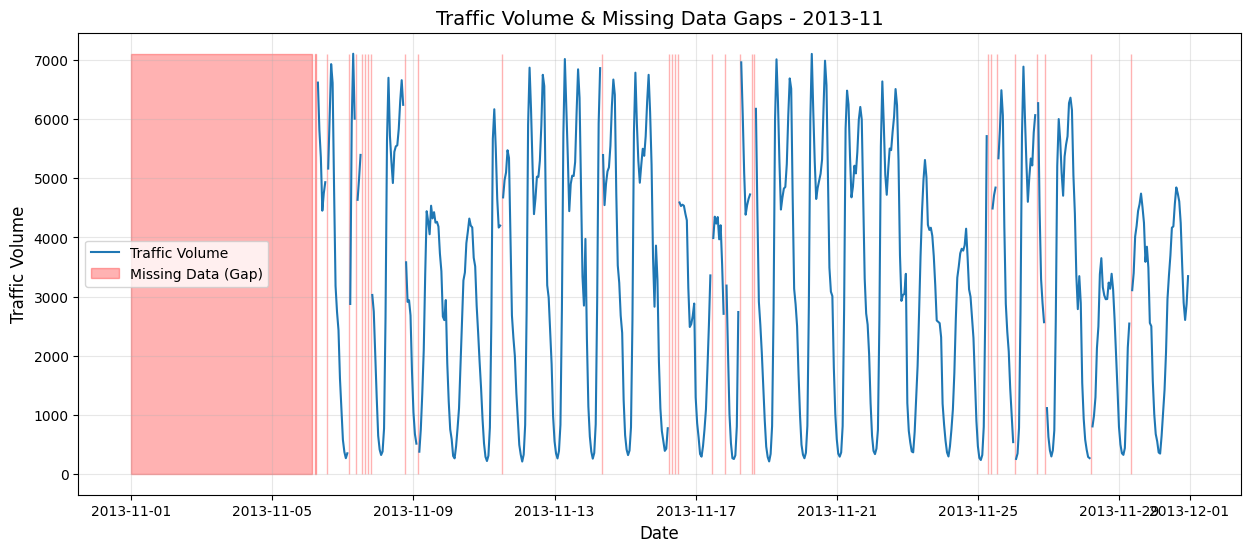

--- Analyzing: 2014-06 ---
Total hours: 720
Missing hours: 406 (56.39%)


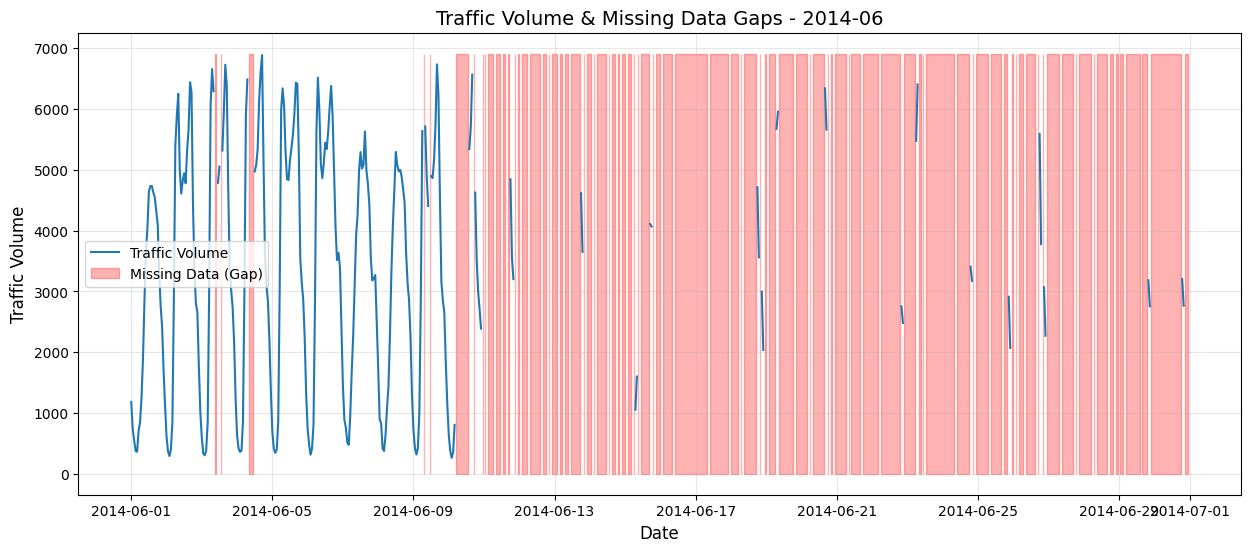

--- Analyzing: 2015-10 ---
Total hours: 744
Missing hours: 257 (34.54%)


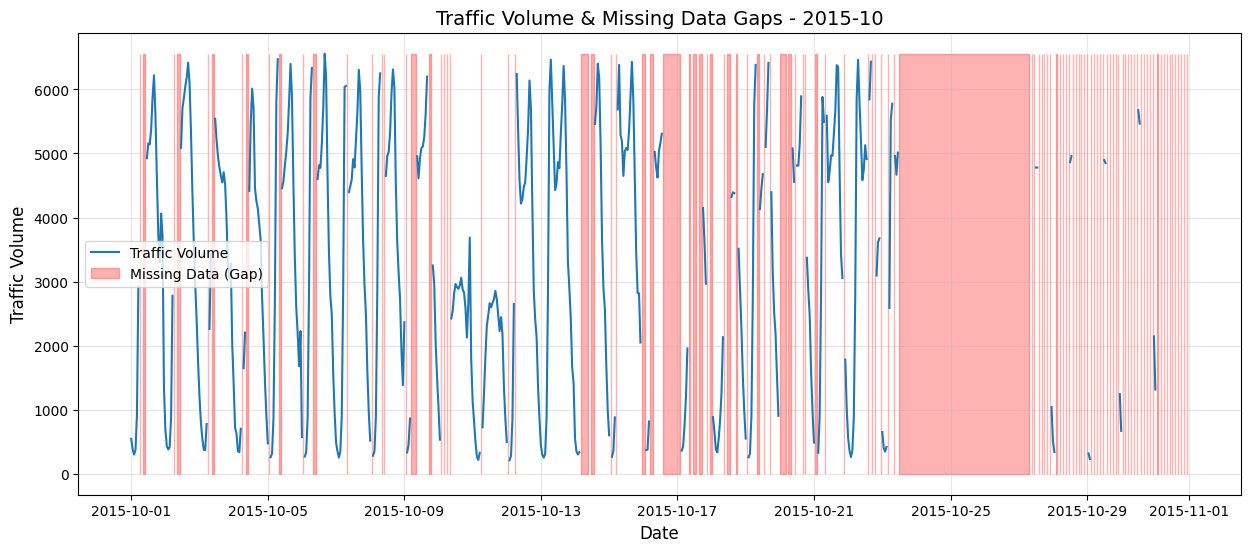

--- Analyzing: 2015-11 ---
Total hours: 720
Missing hours: 324 (45.00%)


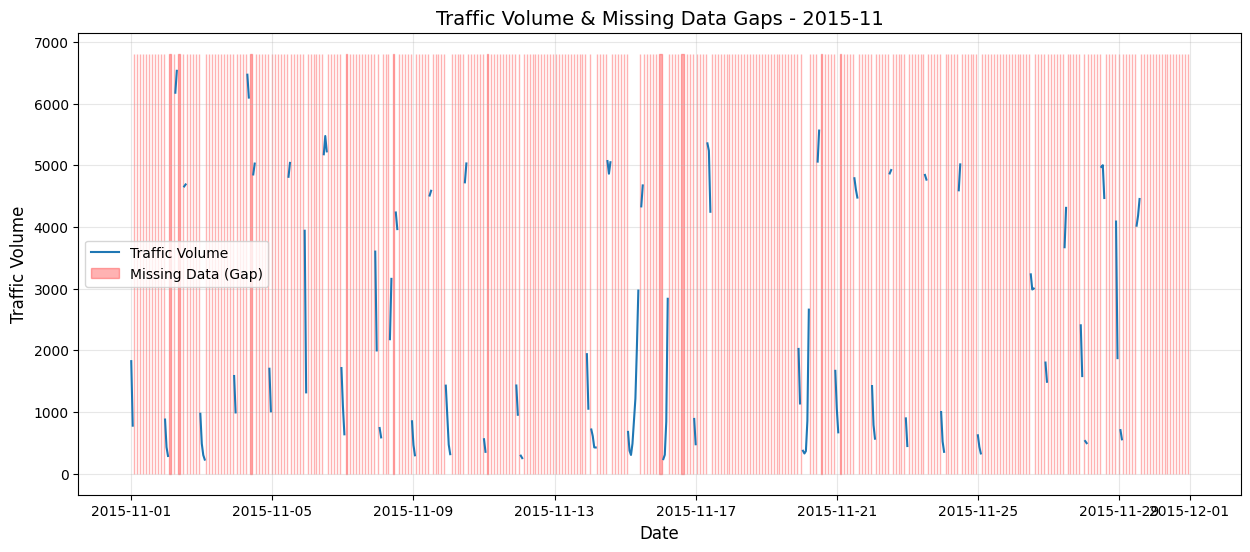

--- Analyzing: 2015-12 ---
Total hours: 744
Missing hours: 305 (40.99%)


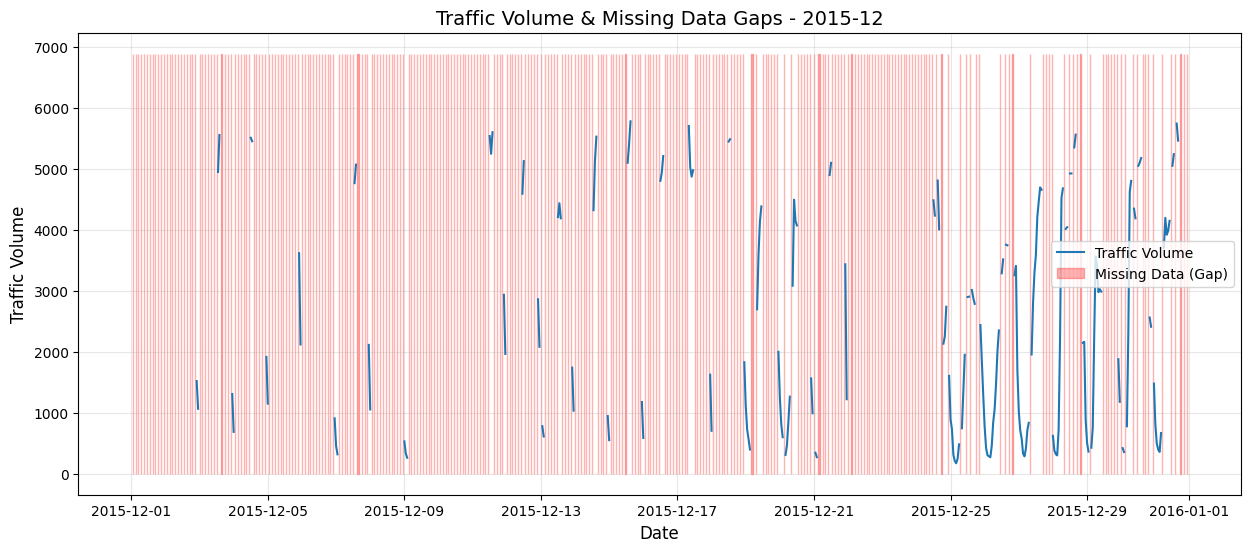

--- Analyzing: 2016-01 ---
Total hours: 744
Missing hours: 283 (38.04%)


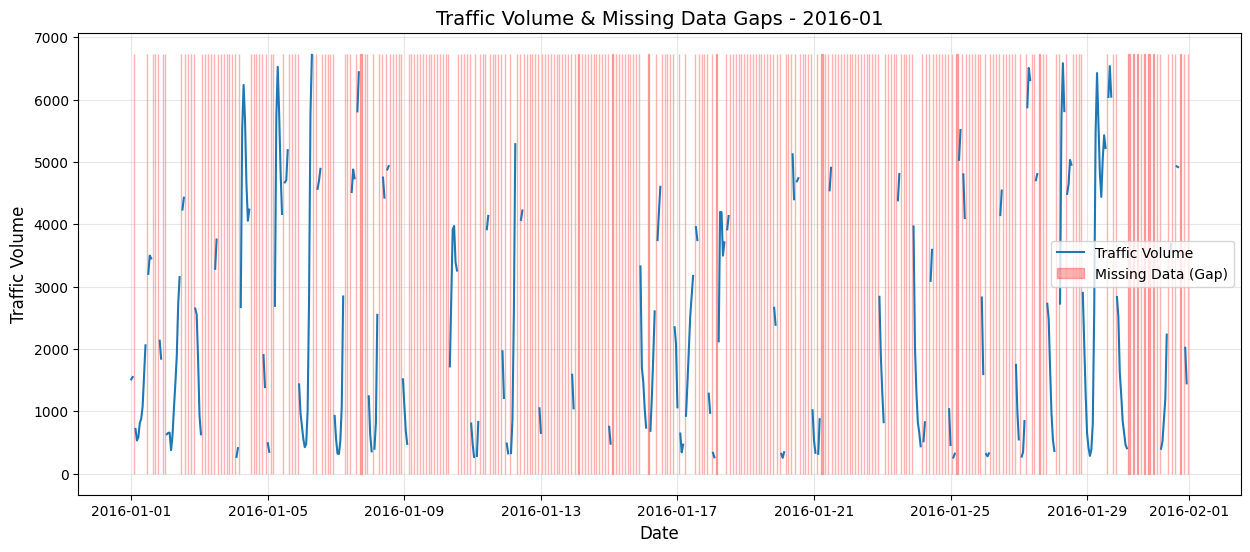

--- Analyzing: 2016-02 ---
Total hours: 696
Missing hours: 187 (26.87%)


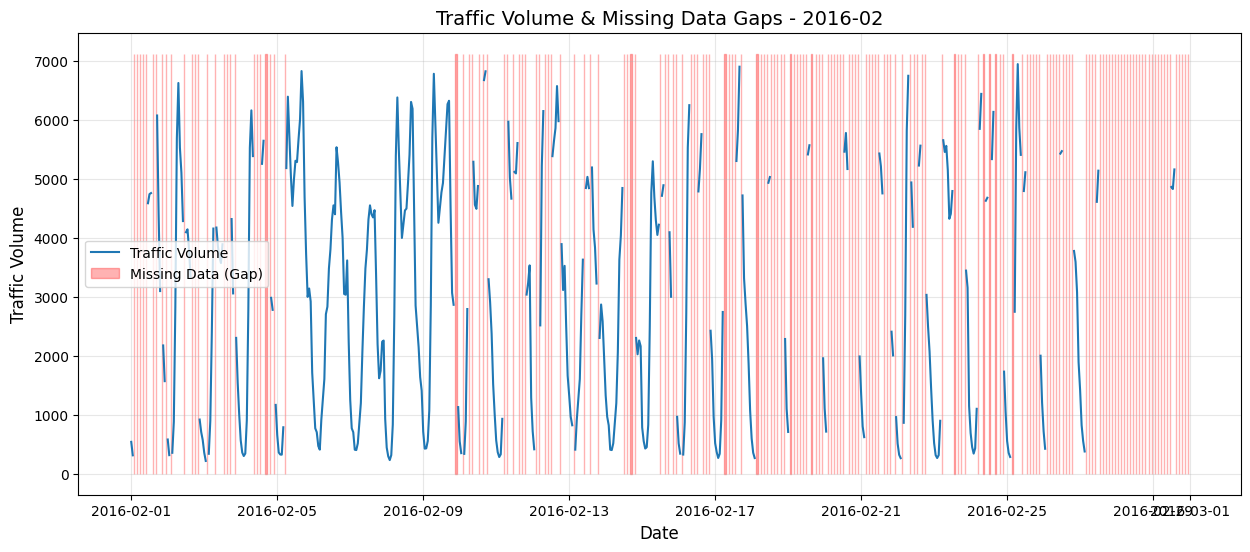

--- Analyzing: 2016-03 ---
Total hours: 744
Missing hours: 272 (36.56%)


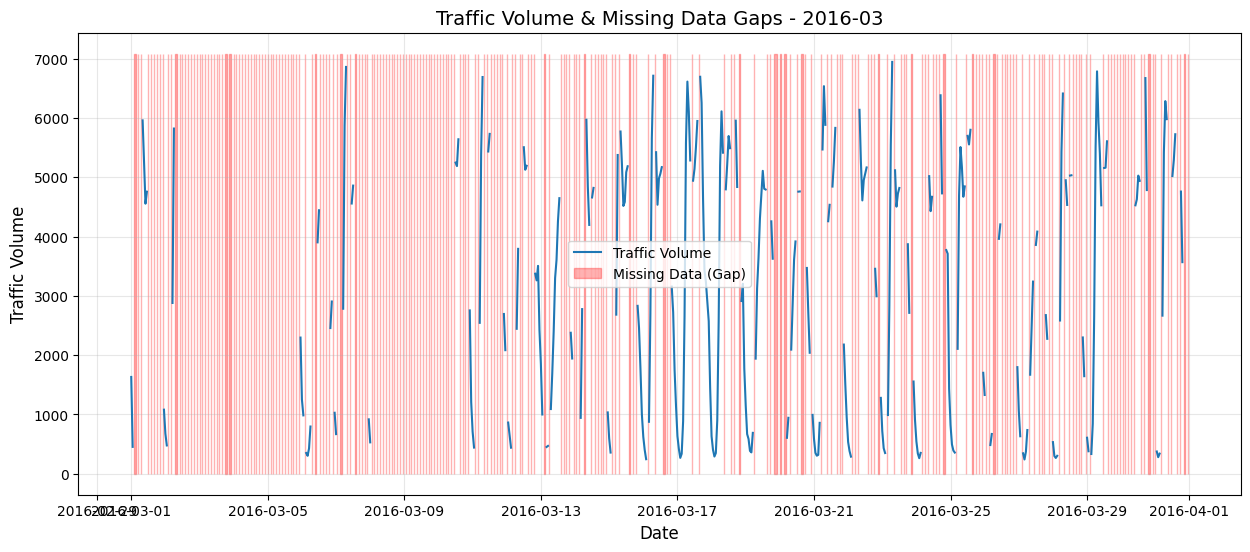

In [33]:
import calendar

def plot_traffic_gaps(df, year, month):
    """
    Plots traffic volume for a specific month to visualize missing data gaps.
    
    Parameters:
    - df: DataFrame with a DatetimeIndex and a 'traffic_volume' column.
    - year: int, the year to analyze.
    - month: int, the month to analyze.
    """
    
    # 1. Define the full date range for the specific month
    # calendar.monthrange returns (first_weekday, number_of_days)
    _, num_days = calendar.monthrange(year, month)
    
    start_date = f"{year}-{month:02d}-01 00:00:00"
    end_date = f"{year}-{month:02d}-{num_days} 23:00:00"
    
    # Create a complete hourly index for this month (Ideal scenario)
    full_range = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # 2. Reindex the DataFrame to reveal gaps
    # We slice the original df for the period to speed up processing, then reindex.
    # .reindex() adds rows for missing timestamps and fills them with NaN.
    # Ensure your df index is sorted before slicing!
    subset = df.loc[start_date:end_date].reindex(full_range)
    
    # Calculate missing stats
    total_hours = len(full_range)
    missing_hours = subset['traffic_volume'].isna().sum()
    missing_pct = (missing_hours / total_hours) * 100
    
    print(f"--- Analyzing: {year}-{month:02d} ---")
    print(f"Total hours: {total_hours}")
    print(f"Missing hours: {missing_hours} ({missing_pct:.2f}%)")
    
    # 3. Plotting
    plt.figure(figsize=(15, 6))
    
    # Plot the traffic volume (gaps will automatically be broken lines or empty spaces)
    plt.plot(subset.index, subset['traffic_volume'], label='Traffic Volume', color='tab:blue')
    
    # Highlight missing areas in red for better visibility
    # isna() returns True for missing values
    missing_mask = subset['traffic_volume'].isna()
    
    # We create a dummy series to fill the background
    # fill_between works with x-axis and y-boundaries
    plt.fill_between(subset.index, 
                     0, 
                     subset['traffic_volume'].max(), 
                     where=missing_mask, 
                     color='red', 
                     alpha=0.3, 
                     label='Missing Data (Gap)')
    
    plt.title(f"Traffic Volume & Missing Data Gaps - {year}-{month:02d}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Traffic Volume", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Execution for the suspect periods ---

print("\n--- Plotting Gaps for Months to Investigate ---")
for (year, month), pct in months_to_investigate.items():
    plot_traffic_gaps(df, year, month)

## Univariate Analysis